<a href="https://colab.research.google.com/github/EugenHotaj/pytorch-generative/blob/master/notebooks/__draft__bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, spatial

In [96]:
def sausage_plot(X, Y=None, mu_sig=None, fn=None, obs=None):
    """Creates a sausage plot of a 1D Gaussian process. 

    Args:
        X: (n x 1) array containing the x-axis coordinates.
        Y: (n x k) array containing k samples drawn from the Gaussian process at X.
        mu_sig: Tuple of (n x 1) arrays containing the marginal (means, stds) at X. If
            provided the means and 95% credible intervals are plotted.
        fn: True (noiseless) function being modeled by the Gaussian process. If 
            provided, fn(X) is plotted.
        obs: Tuple of (possibly noisy) observations from the true function.
    """
    assert any([Y is not None, mu_sig is not None, fn is not None])

    fig = plt.figure(figsize=(20, 4))
    y_max = []
 
    # Plot samples.
    if Y is not None:
        for i in range(Y.shape[0]): 
            sample = Y[i, :]
            plt.plot(X, sample, color="tab:orange")
            y_max.append(sample)

    # Plot mean and credible intervals.
    if mu_sig is not None:
        mu, sigma = mu_sig
        lower_bound, upper_bound = mu - 1.96 * sigma, mu + 1.96 * sigma
        plt.fill_between(X, lower_bound, upper_bound, facecolor='lightblue')
        plt.plot(X, mu, c="tab:blue")
        y_max.extend([lower_bound, upper_bound, mu])

    # Plot the true function.
    if fn is not None:
        Y = fn(X)
        plt.plot(X, Y, color="tab:red", linestyle="dashed")
        y_max.append(Y)

    # Plot observations.
    if obs is not None:
        obs_x, obs_y = obs
        plt.scatter(obs_x[:-1], obs_y[:-1], color="tab:red", marker="x", s=128)
        plt.scatter(obs_x[-1], obs_y[-1], color="tab:green", marker="x", s=128)
        y_max.append(obs_y)

    # Set axis limits.
    plt.xlim(X.min(), X.max())
    y_max = max([np.abs(y).max() for y in y_max])
    plt.ylim(-y_max - .5, y_max + .5)

### Gaussian Processes

In [101]:
class GaussianProcess:
    def __init__(self, mu_fn, sig_fn, obs_noise=0.0):
        self.mu_fn = mu_fn 
        self._sig_fn = sig_fn 
        self.obs_noise = obs_noise 
        self.obs_x, obs_y = None, None

    def fit(self, x, y):
        if self.obs_x is None:
            self.obs_x, self.obs_y = x.reshape(-1, 1), y.reshape(-1, 1)
        else:
            self.obs_x = np.vstack([self.obs_x, x])
            self.obs_y = np.vstack([self.obs_y, y])

    def _sample(self, mu, sigma, n_samples):
        return np.random.multivariate_normal(mu, sigma, size=n_samples)

    def sig_fn(self, l, r, noise=False):
        sig = self._sig_fn(l, r)
        if noise:
            sig += self.obs_noise * np.eye(self.obs_x.shape[0])
        return sig

    def sample(self, x, n_samples=1):
        if self.obs_x is None:
            # Compute prior mean and covariance..
            mu, sig = self.mu_fn(x), self.sig_fn(x, x)
        else:
            # Compute observation, data means and covariances.
            obs_mu, x_mu = self.mu_fn(self.obs_x), self.mu_fn(x)
            obs_sig, x_sig, cross_sig = (
                self.sig_fn(self.obs_x, self.obs_x, noise=True),  
                self.sig_fn(x, x),
                self.sig_fn(self.obs_x, x)
            )
            # Compute posterior mean and covariance.
            solved = linalg.solve(obs_sig, cross_sig, assume_a="pos").T 
            mu = x_mu + solved @ (self.obs_y - obs_mu)
            sig = x_sig - (solved @ cross_sig)

        mu = mu.squeeze()
        samples = self._sample(mu, sig, n_samples)
        return mu, sig, samples

In [102]:
domain = 0, 6
n_grid = 100
n_train = 5
n_samples = 4
noise = 0.1

def f(x, noise=0.):
    y = np.sin(x) 
    if noise:
        y += np.random.normal(size=x.shape) * noise
    return y

grid_x = np.linspace(*domain, n_grid)
train_x = np.random.uniform(*domain, size=(n_train, 1))
train_y = f(train_x, noise)

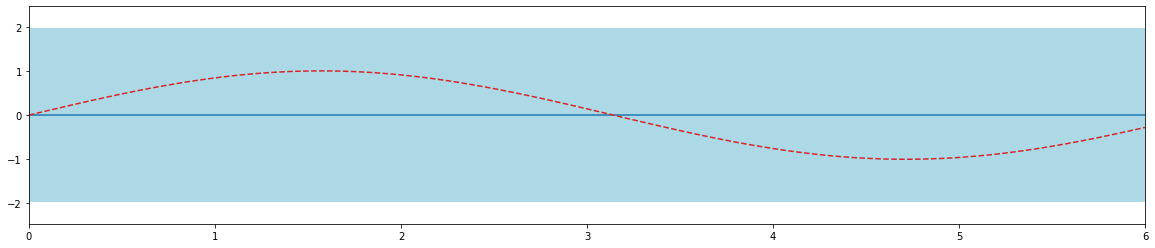

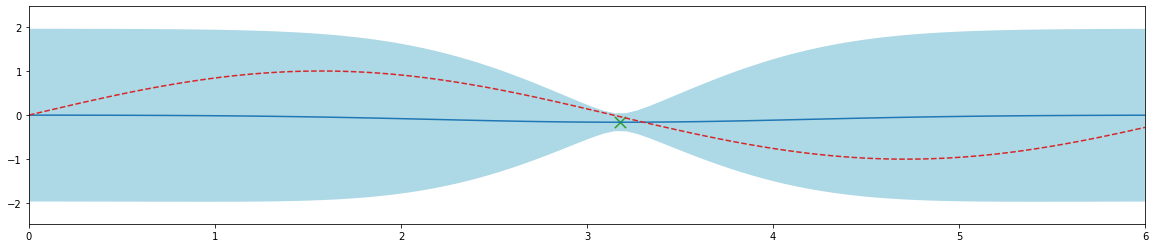

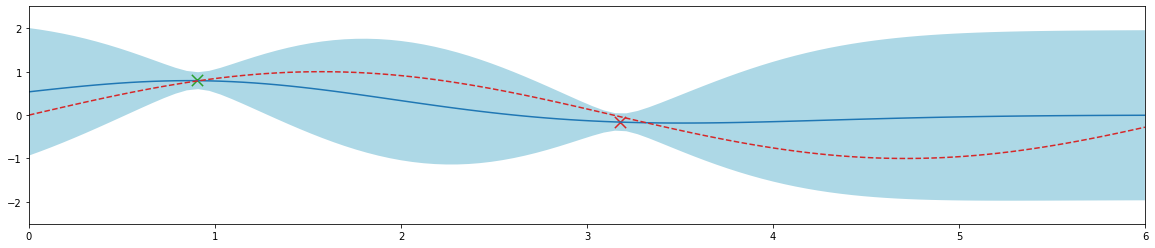

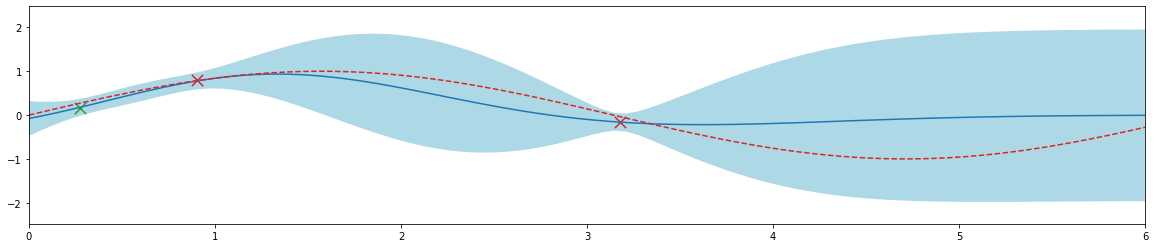

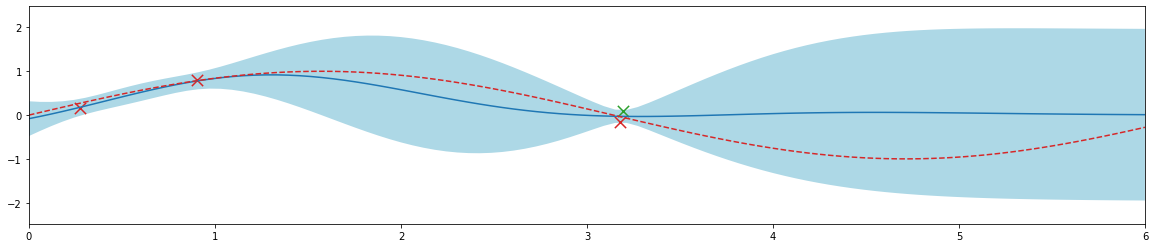

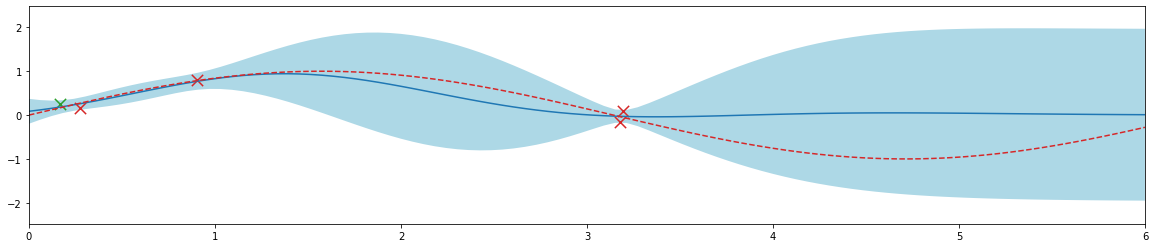

In [103]:
mean_fn = np.zeros_like

def cov_fn(left, right):
    left, right = left.reshape(-1, 1), right.reshape(-1, 1)
    return np.exp(-.5 * spatial.distance.cdist(left, right, 'cityblock')**2)

gp = GaussianProcess(mean_fn, cov_fn, noise**2)

# Sample from prior.
mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples)
sausage_plot(grid_x, None, (mu, np.sqrt(np.diag(sigma))), f)

# Sample from posterior.
for i in range(len(train_x)):
    gp.fit(train_x[i], train_y[i])
    mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples)
    samples = None # Do not plot samples.
    sausage_plot(
        grid_x, 
        samples, 
        (mu, np.sqrt(np.diag(sigma))), 
        f, 
        (train_x[:(i+1)], train_y[:(i+1)]),
    )

### Bayeisan Optimization via Thompson Sampling 

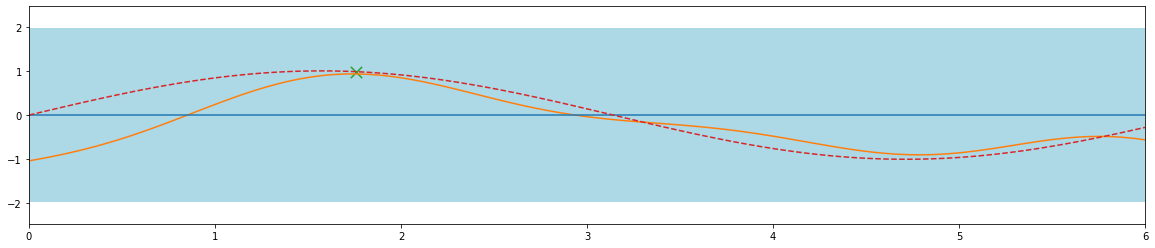

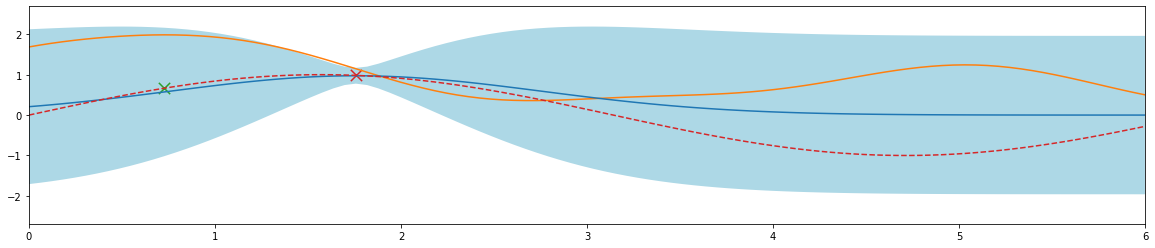

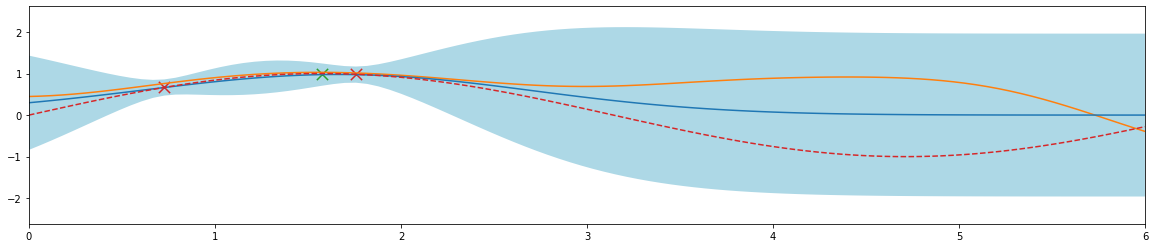

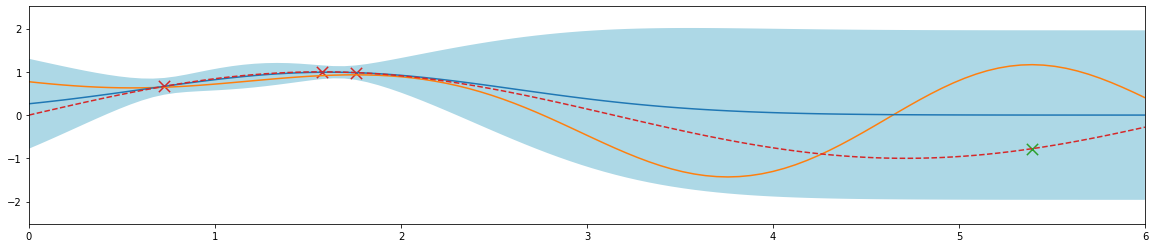

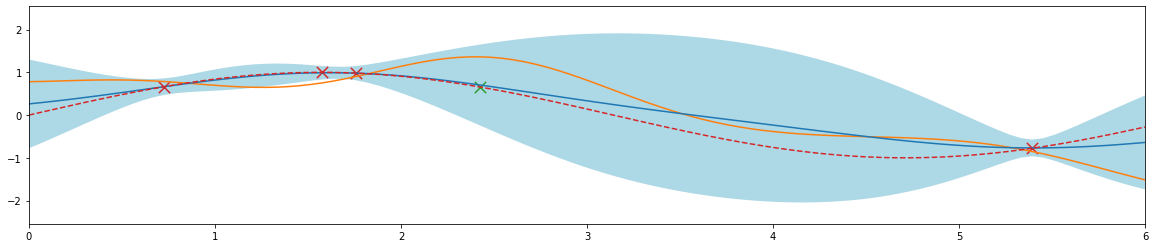

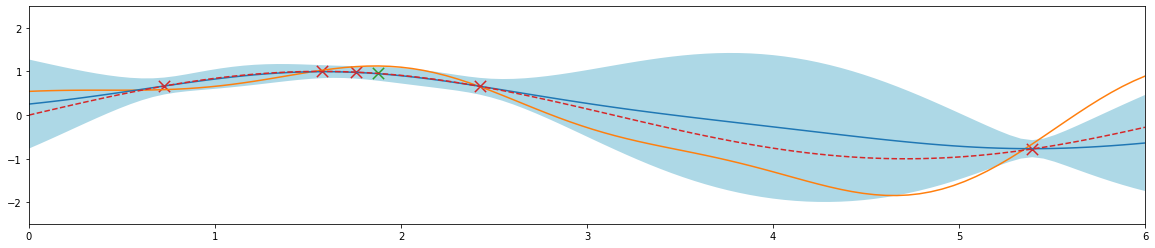

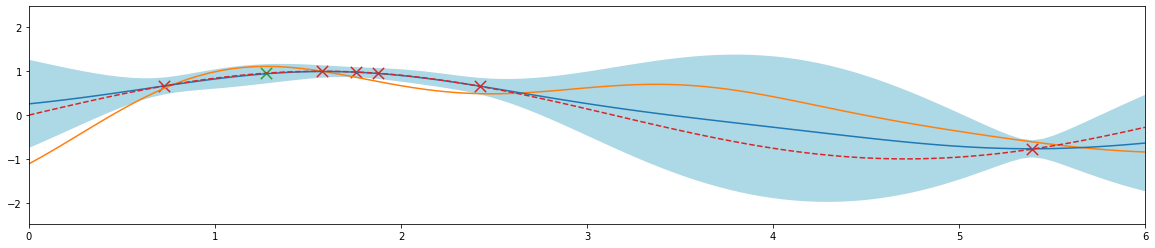

In [107]:
mean_fn = np.zeros_like

def cov_fn(left, right):
    left, right = left.reshape(-1, 1), right.reshape(-1, 1)
    return np.exp(-.5 * spatial.distance.cdist(left, right, 'cityblock')**2)


train_x, train_y = [], []
gp = GaussianProcess(mean_fn, cov_fn, noise**2)
for i in range(7):
    # Get Thompson sample and maximize.
    mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples=1)
    max_idx = np.argmax(samples)
    max_x = grid_x[max_idx]
    max_y = f(max_x)

    # Fit GP for next round.
    train_x.append(max_x)
    train_y.append(max_y)
    gp = GaussianProcess(mean_fn, cov_fn, noise**2)
    gp.fit(np.array(train_x).reshape(-1,1), np.array(train_y).reshape(-1, 1))

    # Plot round.
    sausage_plot(grid_x, samples, (mu, np.sqrt(np.diag(sigma))), f, (train_x, train_y))